# Importation des bibliothéques nécessaires

In [2]:
import os  # Permet de gérer les chemins de fichiers et d'effectuer des opérations de gestion de fichiers.
import rasterio  # Bibliothèque principale pour lire, écrire et manipuler des données raster.
import numpy as np  # Bibliothèque pour le calcul scientifique, utile pour manipuler des tableaux de données numériques.
import matplotlib.pyplot as plt  # Fournit des outils pour créer des graphiques et visualiser les données.
from matplotlib.colors import LinearSegmentedColormap  # Permet de créer des palettes de couleurs personnalisées pour la visualisation des données.
from rasterio.mask import mask  # Fonction pour découper des rasters en utilisant des géométries de masquage spécifiques.
from rasterio.warp import calculate_default_transform, reproject, Resampling  # Fournit des outils pour reprojeter les rasters dans un autre système de coordonnées.
from rasterio.enums import Resampling  # Enumération pour définir les méthodes de rééchantillonnage lors des transformations spatiales des rasters.
import geopandas as gpd  # Extension de pandas pour manipuler des données géospatiales vectorielles (shapefiles, GeoDataFrames).
from matplotlib_scalebar.scalebar import ScaleBar  # Ajoute une barre d'échelle sur les graphiques pour les cartes.
import pandas as pd  # Fournit des outils pour manipuler et analyser des données tabulaires, particulièrement dans des DataFrames.
import rasterstats  # Fournit des fonctions pour calculer des statistiques zonales sur les rasters.
from rasterstats import zonal_stats  # Calcul des statistiques zonales sur les rasters.
import folium  # Bibliothèque pour créer des cartes interactives.
import branca.colormap as cm  # Fournit des outils pour créer des cartes de couleurs pour les cartes folium.
from PIL import Image  # Outils pour manipuler et traiter des images.
import io  # Gestion des flux d’entrée et de sortie.
import base64  # Encodage et décodage en base64.
import matplotlib  # Bibliothèque principale pour les visualisations graphiques.
from folium.features import CustomIcon  # Permet de créer des icônes personnalisées sur les cartes folium.
from shapely.geometry import mapping  # Convertir les géométries Shapely en un format compatible avec les masques Rasterio.
import pyogrio  # Permet de lire et écrire des fichiers vectoriels géospatiaux, contournant les limitations de Fiona.
from rasterio.transform import Affine  # Utilisé pour les transformations spatiales.
from rasterio.features import geometry_mask  # Crée un masque binaire en fonction de géométries spécifiées.

# Question 1: Importer et visualiser les données sur la population

In [3]:
# Définition de notre working directory
directory='C:/Users/ALIOUNE KANE/Downloads/Statistique-Exploratoire-Spatiale/Statistique-Exploratoire-Spatiale/TP5/Groupe - Python'
os.chdir(directory)
pop_raster_chemin="BFA/BFA_population_v1_1_gridded.tif"
#pop_raster_chemin2="BFA/pop_5km_data.tiff"
shapefile_pays_chemin = "bfa_adm_igb_20200323_shp/bfa_admbnda_adm0_igb_20200323.shp"

### Importation du raster (on vérifiera si la taille du pixel = 100 m)

In [4]:
#1. Importation et visualisation les données sur la population (on verifiera si la taille des pixels=100m)
with rasterio.open(pop_raster_chemin) as population_raster:
    # Afficher les infos sur le raster
    print(f"Nombre de bandes : {population_raster.count}")
    print(f"Dimensions (hauteur, largeur) : {population_raster.height}, {population_raster.width}")
    print(f"Type de données : {population_raster.dtypes}")
    print(f"Système de projection : {population_raster.crs}")
    print(f"Transformation affine : {population_raster.transform}")
    print(f"Valeurs manquantes : {population_raster.nodata}")
    print(f"Étendue (coordonnées des bords) : {population_raster.bounds}\n")
    
    pop_data = population_raster.read(1)  # Lire la première bande de données
    pixel_size = population_raster.res[0]* 111320  # Obtenir la taille des pixels en mètres 
    print("Taille du pixel :", pixel_size, "m")  # Vérifier la taille du pixel (devrait être 100m)

Nombre de bandes : 1
Dimensions (hauteur, largeur) : 7019, 9722
Type de données : ('float32',)
Système de projection : EPSG:4326
Transformation affine : | 0.00, 0.00,-5.60|
| 0.00,-0.00, 15.17|
| 0.00, 0.00, 1.00|
Valeurs manquantes : -3.3999999521443642e+38
Étendue (coordonnées des bords) : BoundingBox(left=-5.60291663, bottom=9.324583498, right=2.4987500040000006, top=15.173750141)

Taille du pixel : 92.76666629262293 m


#### Visualisation des données sur la population

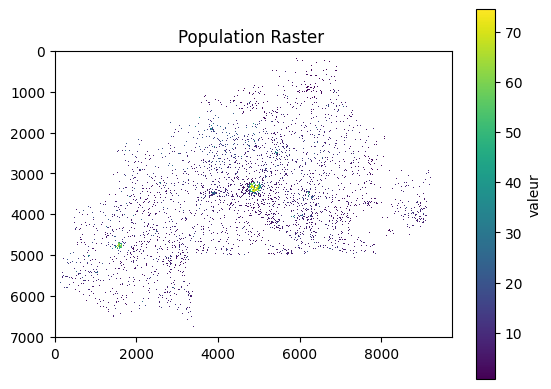

In [5]:
    nodata= population_raster.nodata
    # Appliquer un masque pour les valeurs nodata
    pop_data = np.where(pop_data == nodata,np.nan, pop_data)
    # Afficher le raster de la population
    plt.imshow(pop_data, cmap="viridis",interpolation="none") #pour voir l'image
    plt.title("Population Raster ")
    plt.colorbar(label= "valeur")
    plt.show()

### **Question 2 : Calculer le nombre de personnes par niveau administratif et exporter sous format .csv**

In [47]:
# Chemin de base du shapefile des niveaux administratifs
chemin_shapefile_base = "bfa_adm_igb_20200323_shp/bfa_admbnda_adm{}_igb_20200323.shp"

# Chemin vers le fichier raster de population
population_raster = "BFA/BFA_population_v1_1_gridded.tif"

# Boucle pour chaque niveau administratif de 0 à 3
for niveau in range(4):
    # Générer le chemin du shapefile pour chaque niveau
    chemin_shapefile = chemin_shapefile_base.format(niveau)

    # Lire le fichier shapefile en utilisant pyogrio directement
    niveau_administratif = pyogrio.read_dataframe(chemin_shapefile)

    # Obtenir les valeurs de pixels par zone sans utiliser 'stats' pour récupérer toutes les valeurs de pixels
    zonal_stats_result = zonal_stats(
        niveau_administratif, population_raster, stats=None, nodata=-3.3999999521443642e+38, raster_out=True, all_touched=True
    )

    # Calculer la moyenne arithmétique pour chaque zone et ajouter les résultats
    arith_mean_values = []
    for stat in zonal_stats_result:
        # Récupérer les valeurs de pixels (si elles existent)
        pixel_values = stat['mini_raster_array']

        # Appliquer le masque pour exclure les valeurs manquantes ou négatives
        positive_values = pixel_values[(pixel_values > 0) & (~np.isnan(pixel_values))]

        # Calculer la somme si des valeurs positives existent
        arith_mean = np.sum(positive_values) if len(positive_values) > 0 else np.nan
        arith_mean_values.append(arith_mean)

    # Ajouter les résultats au GeoDataFrame
    niveau_administratif[f'Population du niveau {niveau}'] = arith_mean_values

    # Afficher les résultats
    colonne_nom = f'ADM{niveau}_FR'
    print(niveau_administratif[[colonne_nom, f'Population du niveau {niveau}']])

    # Exporter les résultats dans un fichier CSV
    if niveau == 0:
        nom_csv = "Population_BFA_Pays.csv"
    elif niveau == 1:
        nom_csv = "Population_BFA_Régions.csv"
    elif niveau == 2:
        nom_csv = "Population_BFA_Provinces.csv"
    elif niveau == 3:
        nom_csv = "Population_BFA_Communes.csv"

    niveau_administratif[[colonne_nom, f'Population du niveau {niveau}']].to_csv(nom_csv, index=False)


        ADM0_FR  Population du niveau 0
0  Burkina Faso              20505156.0
              ADM1_FR  Population du niveau 1
0   Boucle du Mouhoun             1902596.375
1            Cascades              812796.500
2              Centre             3031614.000
3          Centre-Est             1582037.375
4         Centre-Nord             1876564.875
5        Centre-Ouest             1661888.125
6          Centre-Sud              790283.375
7                 Est             1944037.125
8       Hauts-Bassins             2240776.750
9                Nord             1723541.125
10    Plateau-Central              980891.250
11              Sahel             1099090.625
12          Sud-Ouest              875794.750
        ADM2_FR  Population du niveau 2
0          Balé            2.978989e+05
1           Bam            4.766603e+05
2         Banwa            3.477762e+05
3        Bazèga            2.818017e+05
4    Bougouriba            1.538088e+05
5       Boulgou            7.387778e

### **Question 3 : A partir du raster brut, ramener la taille des pixels à 5km en faisant une agrégation**

In [48]:
def changer_taille_pixel_avec_agregation(src_path, dst_path, pixels_per_agg):
    """
    Rééchantillonne un raster en sommant les valeurs des pixels agrégés sans reprojection,
    en excluant les valeurs nodata.
    
    :param src_path: Chemin vers le raster source.
    :param dst_path: Chemin vers le raster rééchantillonné.
    :param pixels_per_agg: Nombre de pixels à agréger horizontalement et verticalement.
    """
    with rasterio.open(src_path) as src:
        # Lire les données et métadonnées
        pop_data = src.read(1).astype(np.float64)  # Convertir en float pour éviter les dépassements
        profile = src.profile
        
        # Récupérer la valeur nodata
        nodata = src.nodata
        
        if nodata is not None:
            # Créer un masque où les valeurs sont nodata
            nodata_mask = pop_data == nodata
            # Remplacer les valeurs nodata par 0 pour l'agrégation
            pop_data = np.where(nodata_mask, 0, pop_data)
        else:
            # Si aucune valeur nodata définie, on suppose qu'il n'y a pas de nodata
            nodata_mask = np.zeros(pop_data.shape, dtype=bool)
        
        # Calculer les nouvelles dimensions
        new_height = pop_data.shape[0] // pixels_per_agg
        new_width = pop_data.shape[1] // pixels_per_agg
        
        # Troncature des données pour que les dimensions soient divisibles par pixels_per_agg
        pop_data = pop_data[:new_height * pixels_per_agg, :new_width * pixels_per_agg]
        nodata_mask = nodata_mask[:new_height * pixels_per_agg, :new_width * pixels_per_agg]
        
        # Reshaper les données pour créer des blocs
        pop_data_reshaped = pop_data.reshape(new_height, pixels_per_agg, new_width, pixels_per_agg)
        nodata_mask_reshaped = nodata_mask.reshape(new_height, pixels_per_agg, new_width, pixels_per_agg)
        
        # Somme sur les axes correspondants aux blocs
        pop_sum = pop_data_reshaped.sum(axis=(1, 3))
        
        # Calculer le nombre de pixels valides dans chaque bloc
        valid_pixels = (~nodata_mask_reshaped).sum(axis=(1, 3))
        
        # Optionnel : Marquer les blocs entièrement composés de nodata
        if nodata is not None:
            pop_sum = np.where(valid_pixels > 0, pop_sum, nodata)
        
        # Mettre à jour la transformation affine pour refléter la nouvelle résolution
        new_transform = src.transform * Affine.scale(pixels_per_agg, pixels_per_agg)
        
        # Mettre à jour le profil pour le nouveau raster
        profile.update({
            'height': new_height,
            'width': new_width,
            'transform': new_transform,
            'dtype': pop_sum.dtype,
            'nodata': nodata  # Conserver la valeur nodata si définie
        })
        
        # Écrire le nouveau raster avec les données sommées
        with rasterio.open(dst_path, 'w', **profile) as dst:
            dst.write(pop_sum, 1)

    print(f"Raster rééchantillonné par somme sauvegardé sous : {dst_path}")
    

# === Paramètres ===
# Remplacez les chemins ci-dessous par les chemins réels de vos fichiers raster
pop_raster_chemin = pop_raster_chemin     # Chemin de votre raster original
dst_raster_sum = 'population_5km_sum.tif'          # Nom du fichier final rééchantillonné
pixels_per_agg = 50                                       # Nombre de pixels à agréger (exemple pour 5 km)

# === Étape : Rééchantillonner par somme sans reprojection ===
changer_taille_pixel_avec_agregation(pop_raster_chemin, dst_raster_sum, pixels_per_agg)

def changer_taille_pixel_avec_agregation(src_path, dst_path, pixels_per_agg):
    """
    Rééchantillonne un raster en sommant les valeurs des pixels agrégés sans reprojection,
    en excluant les valeurs nodata.
    
    :param src_path: Chemin vers le raster source.
    :param dst_path: Chemin vers le raster rééchantillonné.
    :param pixels_per_agg: Nombre de pixels à agréger horizontalement et verticalement.
    """
    with rasterio.open(src_path) as src:
        # Lire les données et métadonnées
        pop_data = src.read(1).astype(np.float64)  # Convertir en float pour éviter les dépassements
        profile = src.profile
        
        # Récupérer la valeur nodata
        nodata = src.nodata
        
        if nodata is not None:
            # Créer un masque où les valeurs sont nodata
            nodata_mask = pop_data == nodata
            # Remplacer les valeurs nodata par 0 pour l'agrégation
            pop_data = np.where(nodata_mask, 0, pop_data)
        else:
            # Si aucune valeur nodata définie, on suppose qu'il n'y a pas de nodata
            nodata_mask = np.zeros(pop_data.shape, dtype=bool)
        
        # Calculer les nouvelles dimensions
        new_height = pop_data.shape[0] // pixels_per_agg
        new_width = pop_data.shape[1] // pixels_per_agg
        
        # Troncature des données pour que les dimensions soient divisibles par pixels_per_agg
        pop_data = pop_data[:new_height * pixels_per_agg, :new_width * pixels_per_agg]
        nodata_mask = nodata_mask[:new_height * pixels_per_agg, :new_width * pixels_per_agg]
        
        # Reshaper les données pour créer des blocs
        pop_data_reshaped = pop_data.reshape(new_height, pixels_per_agg, new_width, pixels_per_agg)
        nodata_mask_reshaped = nodata_mask.reshape(new_height, pixels_per_agg, new_width, pixels_per_agg)
        
        # Somme sur les axes correspondants aux blocs
        pop_sum = pop_data_reshaped.sum(axis=(1, 3))
        
        # Calculer le nombre de pixels valides dans chaque bloc
        valid_pixels = (~nodata_mask_reshaped).sum(axis=(1, 3))
        
        # Optionnel : Marquer les blocs entièrement composés de nodata
        if nodata is not None:
            pop_sum = np.where(valid_pixels > 0, pop_sum, nodata)
        
        # Mettre à jour la transformation affine pour refléter la nouvelle résolution
        new_transform = src.transform * Affine.scale(pixels_per_agg, pixels_per_agg)
        
        # Mettre à jour le profil pour le nouveau raster
        profile.update({
            'height': new_height,
            'width': new_width,
            'transform': new_transform,
            'dtype': pop_sum.dtype,
            'nodata': nodata  # Conserver la valeur nodata si définie
        })
        
        # Écrire le nouveau raster avec les données sommées
        with rasterio.open(dst_path, 'w', **profile) as dst:
            dst.write(pop_sum, 1)

    print(f"Raster rééchantillonné par somme sauvegardé sous : {dst_path}")
    

# === Paramètres ===
# Remplacez les chemins ci-dessous par les chemins réels de vos fichiers raster
pop_raster_chemin = pop_raster_chemin     # Chemin de votre raster original
dst_raster_sum = 'population_5km_sum.tif'          # Nom du fichier final rééchantillonné
pixels_per_agg = 50                                       # Nombre de pixels à agréger (exemple pour 5 km)

# === Étape : Rééchantillonner par somme sans reprojection ===
changer_taille_pixel_avec_agregation(pop_raster_chemin, dst_raster_sum, pixels_per_agg)

Raster rééchantillonné par somme sauvegardé sous : population_5km_sum.tif
Raster rééchantillonné par somme sauvegardé sous : population_5km_sum.tif


### **Question 4 :  Visualiser le nouveau raster de la population**

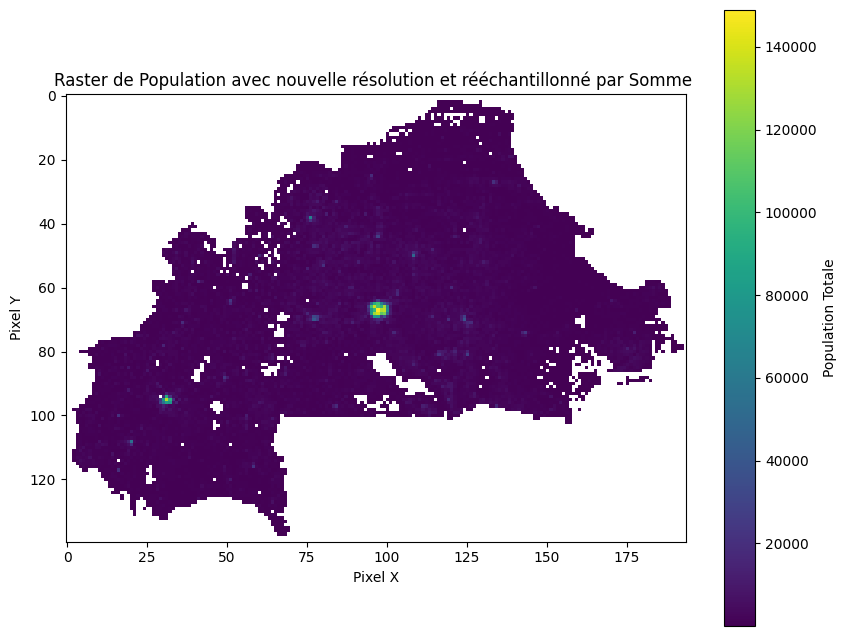

In [16]:
# === Visualisation ===
with rasterio.open('population_5km_sum.tif') as raster_5km:
    data_5km = raster_5km.read(1)
        
    # Appliquer un masque pour les valeurs nodata si nécessaire
    if raster_5km.nodata is not None:
        data_5km = np.where(data_5km == raster_5km.nodata, np.nan, data_5km)
        # Afficher le raster rééchantillonné
    plt.figure(figsize=(10, 8))
    plt.imshow(data_5km, cmap="viridis")
    plt.title("Raster de Population avec nouvelle résolution et rééchantillonné par Somme ")
    plt.colorbar(label="Population Totale")
    plt.xlabel("Pixel X")
    plt.ylabel("Pixel Y")
    plt.show()

### **Question 5 : A partir du nouveau raster de la population, calculer un nouveau raster en multipliant par 0,1% (qui représente la part des enfants dans la population totale)**

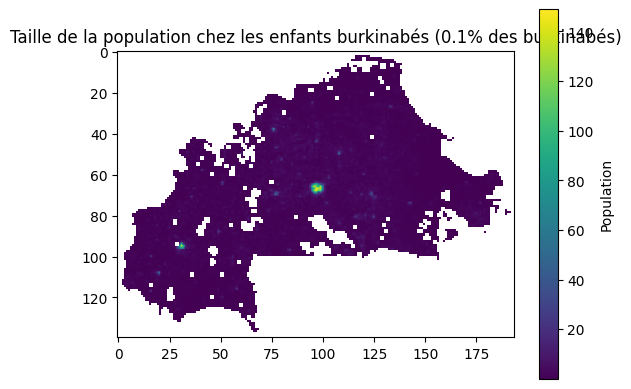

In [49]:
# Création d'un nouveau raster en multipliant le raster pop_5km_data par 0,1%

taux_enfants_burkinabe=0.001 # Les enfants représentent 0.1% de la population burkinabé
enfants_bfa_raster = data_5km * taux_enfants_burkinabe  # Réduire les valeurs de 0,1%
plt.imshow(enfants_bfa_raster, cmap="viridis")
plt.title("Taille de la population chez les enfants burkinabés (0.1% des burkinabés)")
plt.colorbar(label="Population")
plt.show()

# Enregistrement du raster
# Chemin de sortie pour le raster enfants_bfa_raster
cheminraster_enfants_bfa = "enfants_bfa_raster.tif"

# Charger le profil du raster pop_5km_data pour obtenir les métadonnées nécessaires
with rasterio.open("population_5km_sum.tif") as src:
    profile = src.profile  # Garder le profil pour l'enregistrement

# Enregistrement du raster d'enfants
with rasterio.open(
    cheminraster_enfants_bfa, 'w', driver='GTiff',
    height=enfants_bfa_raster.shape[0], 
    width=enfants_bfa_raster.shape[1],
    count=1, dtype=enfants_bfa_raster.dtype,
    crs=profile['crs'], transform=profile['transform']
) as dst:
    dst.write(enfants_bfa_raster.astype(np.float32), 1)

### **Question 6 : Créer trois nouveaux raster binarisés à partir du raster sur le taux de malaria pour l'année 2022**

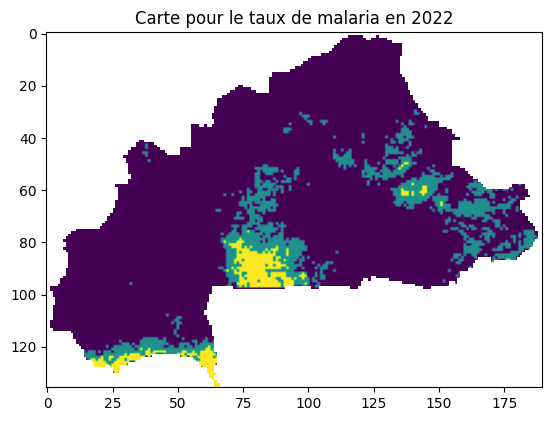

Raster sauvegardé sous : aucun.tif
Raster sauvegardé sous : modere.tif
Raster sauvegardé sous : grave.tif


In [50]:
# Importons d'abord le raster carte risque 2022
with rasterio.open('carte_risque_2022.tiff') as carte_risque:
    data_risque = carte_risque.read(1)
    plt.imshow(data_risque)
    plt.title("Carte pour le taux de malaria en 2022")
    plt.show()

# Créer trois rasters binarisés : aucun, modéré, grave
aucun = np.where(data_risque == 1, 1, 0)
modere = np.where(data_risque == 2, 1, 0)
grave = np.where(data_risque == 3, 1, 0)

# Chemin de sortie pour les rasters binarisés
chemin_aucun = "aucun.tif"
chemin_modere = "modere.tif"
chemin_grave = "grave.tif"

# Charger le profil du raster de population pour obtenir les métadonnées nécessaires
with rasterio.open("population_5km_sum.tif") as src:
    profile = src.profile  # Garder le profil pour l'enregistrement

# Mettre à jour le profil pour enregistrer un seul canal (1 couche) et un nodata compatible avec uint8
profile.update(dtype=rasterio.uint8, count=1, nodata=0)

# Fonction pour sauvegarder un raster binaire
def sauvegarder_raster(binarized_data, chemin_sortie, profile):
    with rasterio.open(chemin_sortie, 'w', **profile) as dst:
        dst.write(binarized_data.astype(rasterio.uint8), 1)  # Assure le type uint8
    print(f"Raster sauvegardé sous : {chemin_sortie}")

# Sauvegarder les trois rasters binarisés
sauvegarder_raster(aucun, chemin_aucun, profile)
sauvegarder_raster(modere, chemin_modere, profile)
sauvegarder_raster(grave, chemin_grave, profile)


#### Visualisation des rasters binarisés

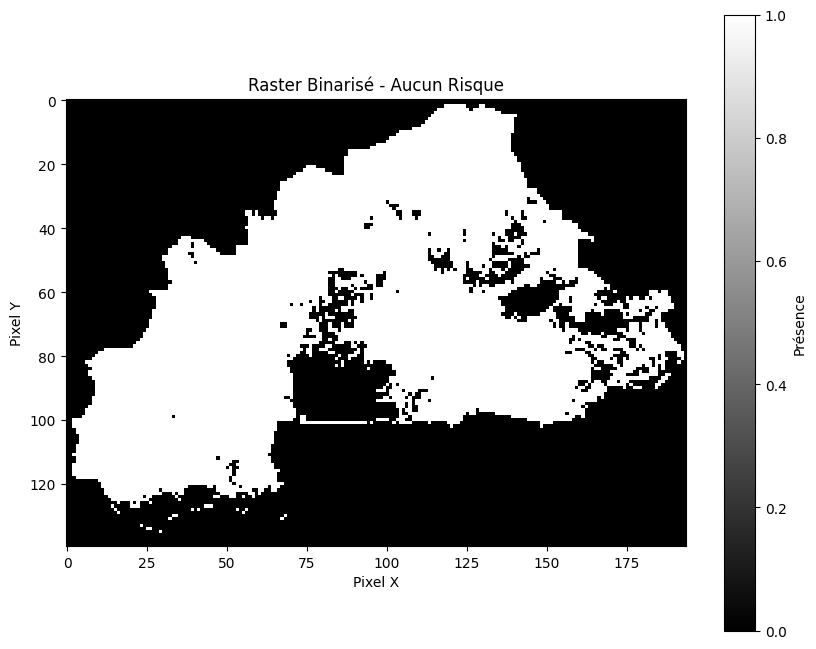

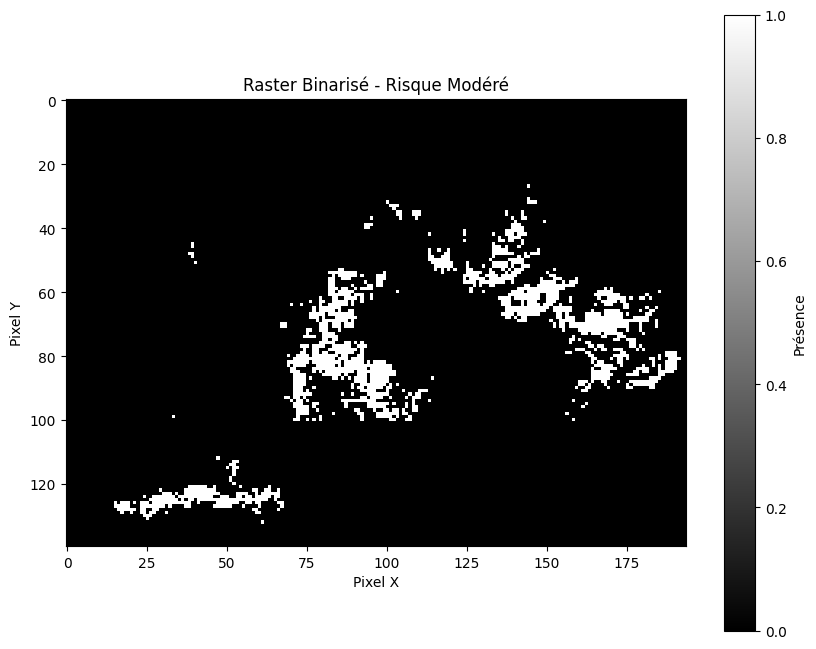

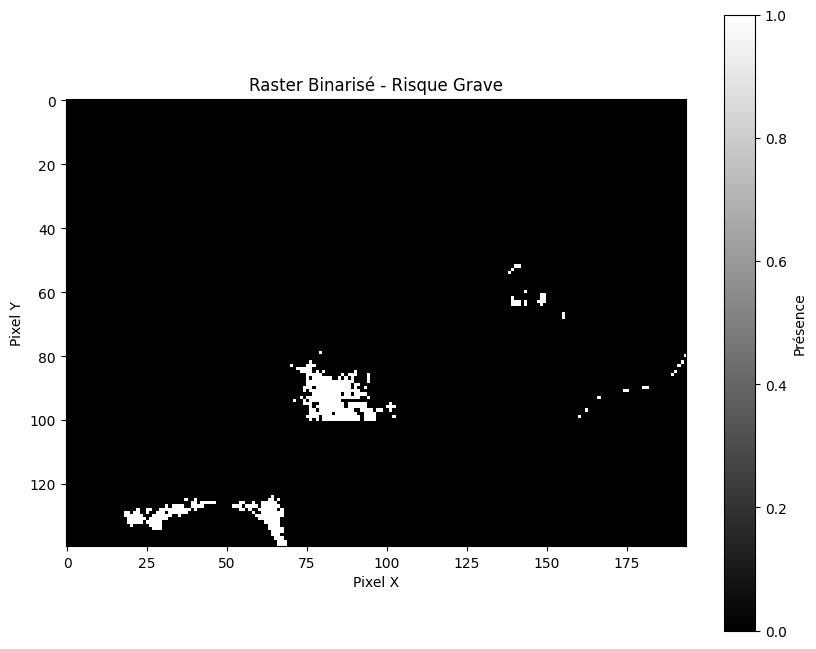

In [51]:
# Visualisation des rasters binarisés
def visualiser_raster(chemin_raster, titre, cmap):
    with rasterio.open(chemin_raster) as src:
        data = src.read(1)
        plt.figure(figsize=(10, 8))
        plt.imshow(data, cmap=cmap)
        plt.title(titre)
        plt.colorbar(label="Présence")
        plt.xlabel("Pixel X")
        plt.ylabel("Pixel Y")
        plt.show()

visualiser_raster('aucun.tif', "Raster Binarisé - Aucun Risque", "gray")
visualiser_raster('modere.tif', "Raster Binarisé - Risque Modéré", "gray")
visualiser_raster('grave.tif', "Raster Binarisé - Risque Grave","gray")

#### Visualisation des rasters binarisés en les clippant avec le shapefile

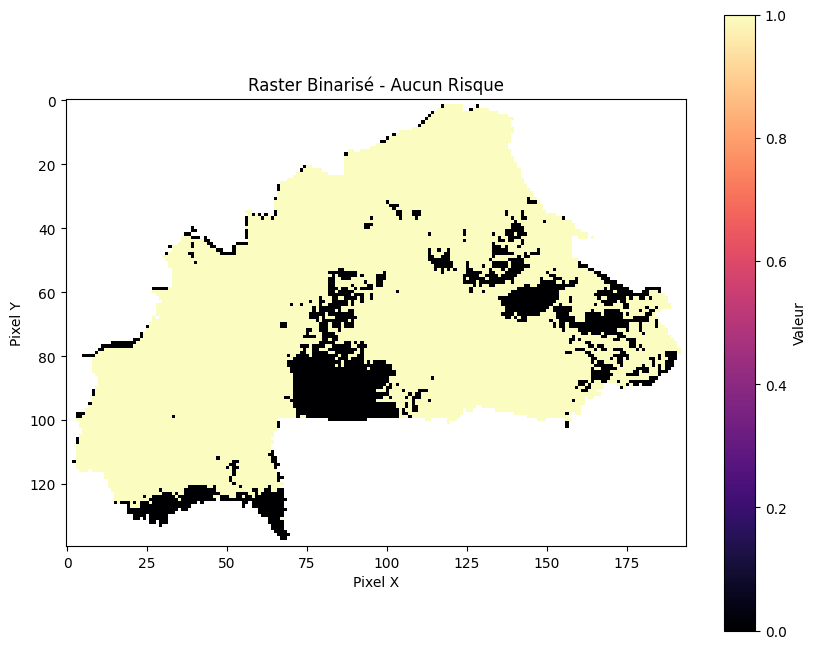

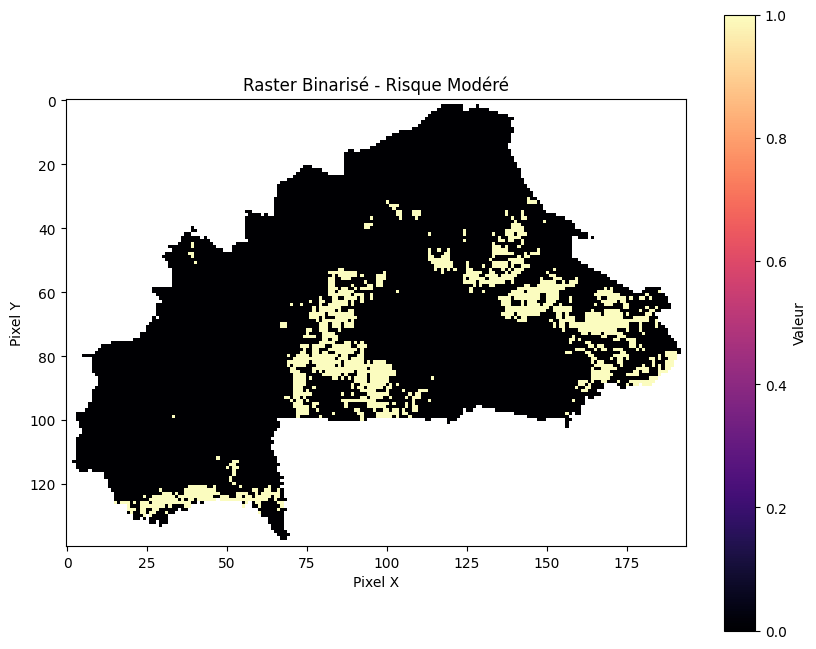

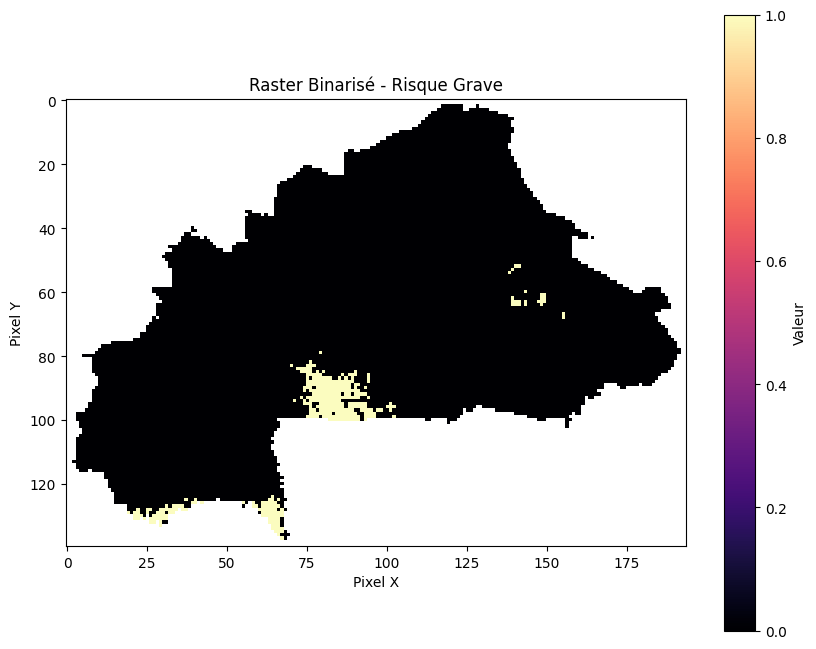

In [52]:
def visualiser_raster_clippe(chemin_raster, titre, cmap, chemin_shapefile):
    """
    Visualise un raster en masquant les zones en dehors du shapefile fourni.
    
    :param chemin_raster: Chemin vers le fichier raster à visualiser.
    :param titre: Titre du graphique.
    :param cmap: Colormap pour l'affichage.
    :param chemin_shapefile: Chemin vers le shapefile pour le masquage.
    """
    # Charger le shapefile avec pyogrio
    shapefile = pyogrio.read_dataframe(chemin_shapefile)
    
    with rasterio.open(chemin_raster) as src:
        data = src.read(1)  # Lire la première bande
        transform = src.transform
        crs = src.crs
        
        # Reprojeter le shapefile si nécessaire
        if shapefile.crs != crs:
            shapefile = shapefile.to_crs(crs)
            print("Shapefile reprojeté pour correspondre au CRS du raster.")
        
        geometries = shapefile.geometry.values  # Extraire les géométries
        
        # Créer un masque où les pixels à l'intérieur du shapefile sont True
        mask = geometry_mask(
            geometries,
            transform=transform,
            invert=True,
            out_shape=(src.height, src.width)
        )
        
        # Appliquer le masque au raster
        data_clippe = np.where(mask, data, np.nan)  # Mettre NaN en dehors du shapefile
        
        # Visualiser le raster masqué
        plt.figure(figsize=(10, 8))
        plt.imshow(data_clippe, cmap=cmap)
        plt.title(titre)
        plt.colorbar(label="Valeur")
        plt.xlabel("Pixel X")
        plt.ylabel("Pixel Y")
        plt.show()


# Modifier le chemin du shapefile pour le visualiser
shapefile_pays_chemin = "bfa_adm_igb_20200323_shp/bfa_admbnda_adm0_igb_20200323.shp"

# Visualiser les rasters binarisés
visualiser_raster_clippe(chemin_aucun, "Raster Binarisé - Aucun Risque", "magma", shapefile_pays_chemin)
visualiser_raster_clippe(chemin_modere, "Raster Binarisé - Risque Modéré", "magma", shapefile_pays_chemin)
visualiser_raster_clippe(chemin_grave, "Raster Binarisé - Risque Grave", "magma", shapefile_pays_chemin)


### **Question 7 : Multiplier chaque raster binarisé par le raster de la population des enfants**

In [53]:
def aligner_raster(source_path, reference_path, destination_path, resampling_method=Resampling.nearest):
    """
    Reprojette et resample un raster source pour qu'il corresponde au raster de référence.

    :param source_path: Chemin vers le raster source à aligner.
    :param reference_path: Chemin vers le raster de référence.
    :param destination_path: Chemin de sortie pour le raster aligné.
    :param resampling_method: Méthode de resampling à utiliser (par défaut : nearest).
    """
    with rasterio.open(reference_path) as ref:
        ref_crs = ref.crs
        ref_transform = ref.transform
        ref_width = ref.width
        ref_height = ref.height
        ref_dtype = ref.dtypes[0]
        ref_nodata = ref.nodata

    with rasterio.open(source_path) as src:
        src_crs = src.crs
        src_transform = src.transform
        src_width = src.width
        src_height = src.height
        src_dtype = src.dtypes[0]
        src_nodata = src.nodata

        # Calculer la transformation et les dimensions pour le raster aligné
        transform, width, height = calculate_default_transform(
            src_crs, ref_crs, src.width, src.height, *src.bounds)

        # Mettre à jour les métadonnées
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': ref_crs,
            'transform': ref_transform,
            'width': ref_width,
            'height': ref_height,
            'dtype': ref_dtype,
            'nodata': ref_nodata
        })

        # Reprojeter et resampler le raster
        with rasterio.open(destination_path, 'w', **kwargs) as dst:
            reproject(
                source=rasterio.band(src, 1),
                destination=rasterio.band(dst, 1),
                src_transform=src_transform,
                src_crs=src_crs,
                dst_transform=ref_transform,
                dst_crs=ref_crs,
                resampling=resampling_method
            )
    print(f"Raster aligné sauvegardé sous : {destination_path}")

In [54]:
# Chemins de sortie pour les rasters alignés
chemin_aucun_aligne = "aucun_aligne.tif"
chemin_modere_aligne = "modere_aligne.tif"
chemin_grave_aligne = "grave_aligne.tif"

# Aligner les rasters binarisés avec le raster de population
aligner_raster("aucun.tif", cheminraster_enfants_bfa, chemin_aucun_aligne, Resampling.nearest)
aligner_raster("modere.tif", cheminraster_enfants_bfa, chemin_modere_aligne, Resampling.nearest)
aligner_raster("grave.tif", cheminraster_enfants_bfa, chemin_grave_aligne, Resampling.nearest)

Raster aligné sauvegardé sous : aucun_aligne.tif
Raster aligné sauvegardé sous : modere_aligne.tif
Raster aligné sauvegardé sous : grave_aligne.tif


In [55]:
# Charger les rasters alignés et multiplier avec enfants_bfa_raster
with rasterio.open(chemin_aucun_aligne) as aucun_aligne:
    data_aucun_malaria = aucun_aligne.read(1)
    profile = aucun_aligne.profile  # Récupérer le profil pour la sauvegarde

with rasterio.open(chemin_modere_aligne) as modere_aligne:
    data_modere_malaria = modere_aligne.read(1)

with rasterio.open(chemin_grave_aligne) as grave_aligne:
    data_grave_malaria = grave_aligne.read(1)

# Multiplication des rasters
pop_enfants_malaria_aucun = enfants_bfa_raster * data_aucun_malaria
pop_enfants_malaria_modere = enfants_bfa_raster * data_modere_malaria
pop_enfants_malaria_grave = enfants_bfa_raster * data_grave_malaria

# Mise à jour du profil pour enregistrer les rasters résultants
profile.update(dtype=rasterio.float32, nodata=np.nan)

# Sauvegarder les trois rasters binarisés
sauvegarder_raster(pop_enfants_malaria_aucun, "pop_enfants_malaria_aucun.tif", profile)
sauvegarder_raster(pop_enfants_malaria_modere, "pop_enfants_malaria_modere.tif", profile)
sauvegarder_raster(pop_enfants_malaria_grave, "pop_enfants_malaria_grave.tif", profile)


Raster sauvegardé sous : pop_enfants_malaria_aucun.tif
Raster sauvegardé sous : pop_enfants_malaria_modere.tif
Raster sauvegardé sous : pop_enfants_malaria_grave.tif


C:\Users\ALIOUNE KANE\AppData\Local\Temp\ipykernel_1400\2255061363.py:28: RuntimeWarning: invalid value encountered in cast
  dst.write(binarized_data.astype(rasterio.uint8), 1)  # Assure le type uint8


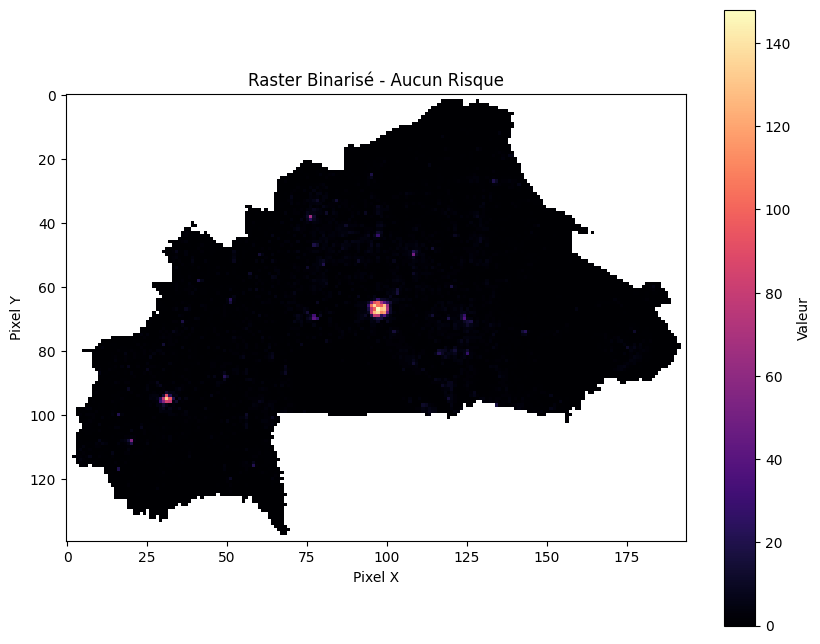

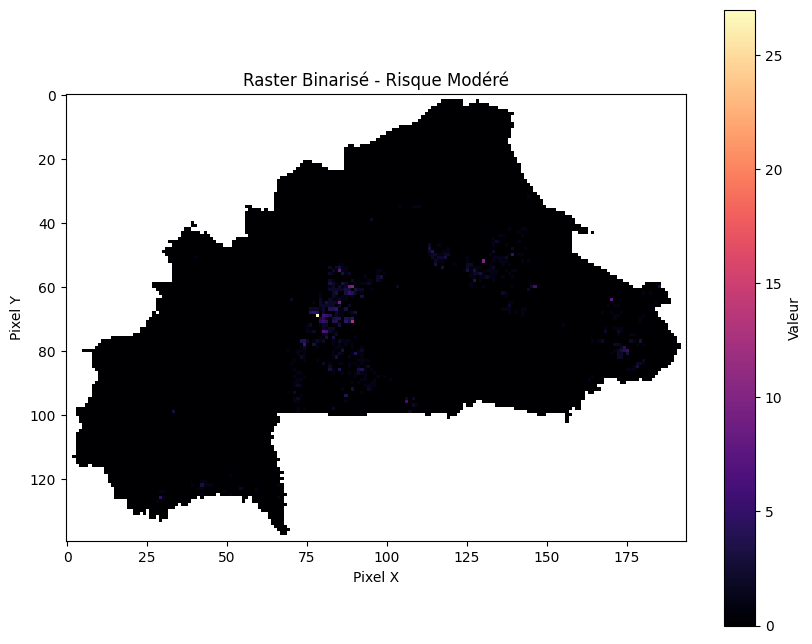

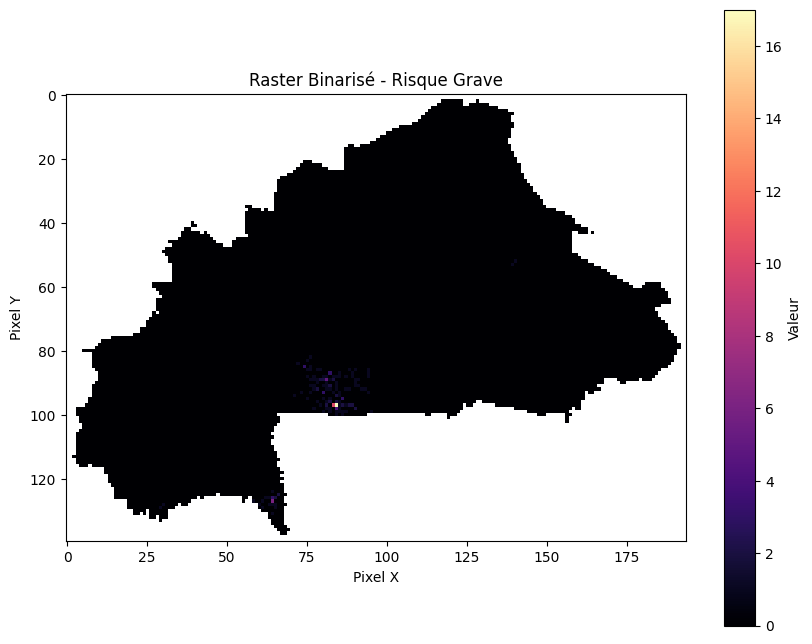

In [35]:
# Visualisons ces rasters
visualiser_raster_clippe("pop_enfants_malaria_aucun.tif", "Raster Binarisé - Aucun Risque", "magma", shapefile_pays_chemin)
visualiser_raster_clippe("pop_enfants_malaria_modere.tif", "Raster Binarisé - Risque Modéré", "magma",shapefile_pays_chemin)
visualiser_raster_clippe("pop_enfants_malaria_grave.tif", "Raster Binarisé - Risque Grave", "magma",shapefile_pays_chemin)

### **Question 8 : Calculer le nombre d'enfants atteints par le malaria par niveau administratif et exporter**

In [56]:
taux_malaria_2022 = '202406_Global_Pf_Parasite_Rate_BFA_2022.tiff'

# Fonction pour aligner les rasters
def aligner_raster(src_raster, ref_raster, out_raster, resampling_method):
    with rasterio.open(src_raster) as src, rasterio.open(ref_raster) as ref:
        # Lire les informations du raster de référence
        transform, width, height = rasterio.warp.calculate_default_transform(
            src.crs, ref.crs, ref.width, ref.height, *ref.bounds)
        
        # Mettre à jour les paramètres du profil
        profile = src.profile
        profile.update(transform=transform, width=width, height=height)
        
        # Aligner et sauvegarder le raster aligné
        with rasterio.open(out_raster, 'w', **profile) as dst:
            rasterio.warp.reproject(
                source=rasterio.band(src, 1),
                destination=rasterio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=ref.crs,
                resampling=resampling_method
            )

# Alignement du raster
aligner_raster(taux_malaria_2022, 'population_5km_sum.tif', 'taux_2022.tiff', Resampling.nearest)

# Lire le raster aligné
with rasterio.open('taux_2022.tiff') as taux_malaria_2022:
    taux_2022_data = taux_malaria_2022.read(1)

# Calculer la population d'enfants atteints de la malaria
pop_enfants_atteints = enfants_bfa_raster * taux_2022_data

# Sauvegarder le raster calculé
def sauvegarder_raster(binarized_data, chemin_sortie, profile):
    profile.update(dtype=rasterio.float32, count=1)
    with rasterio.open(chemin_sortie, 'w', **profile) as dst:
        dst.write(binarized_data, 1)

with rasterio.open("population_5km_sum.tif") as src:
    profile = src.profile

sauvegarder_raster(pop_enfants_atteints, 'pop_enfants_atteints.tiff', profile)

# Chemin de base du shapefile des niveaux administratifs
chemin_shapefile_base = "bfa_adm_igb_20200323_shp/bfa_admbnda_adm{}_igb_20200323.shp"

# Chemin vers le fichier raster de population d'enfants atteints par la malaria
population_enfants_malaria = 'pop_enfants_atteints.tiff'

# Boucle pour chaque niveau administratif de 0 à 3
for niveau in range(4):
    # Générer le chemin du shapefile pour chaque niveau
    chemin_shapefile = chemin_shapefile_base.format(niveau)

    # Lire le fichier shapefile avec pyogrio directement pour contourner l'erreur de fiona
    niveau_administratif = pyogrio.read_dataframe(chemin_shapefile)

    # Obtenir les valeurs de pixels par zone
    zonal_stats_result = zonal_stats(
        niveau_administratif, population_enfants_malaria, stats=None, nodata=None, raster_out=True, all_touched=True
    )

    # Calculer la moyenne arithmétique pour chaque zone et ajouter les résultats
    arith_mean_values = []
    for stat in zonal_stats_result:
        # Récupérer les valeurs de pixels (si elles existent)
        pixel_values = stat['mini_raster_array']

        # Appliquer le masque pour exclure les valeurs manquantes ou négatives
        positive_values = pixel_values[(pixel_values > 0) & (~np.isnan(pixel_values))]

        # Calculer la somme si des valeurs positives existent
        arith_mean = np.sum(positive_values) if len(positive_values) > 0 else np.nan
        arith_mean_values.append(arith_mean)

    # Ajouter les résultats au GeoDataFrame
    niveau_administratif[f'Enfants atteints par la malaria pour le niveau {niveau}'] = arith_mean_values

    # Afficher les résultats
    colonne_nom = f'ADM{niveau}_FR'
    print(niveau_administratif[[colonne_nom, f'Enfants atteints par la malaria pour le niveau {niveau}']])

    # Exporter les résultats dans un fichier CSV
    nom_csv = f"Nombre_enfants_malaria_Niveau_{niveau}.csv"
    niveau_administratif[[colonne_nom, f'Enfants atteints par la malaria pour le niveau {niveau}']].to_csv(nom_csv, index=False)


        ADM0_FR  Enfants atteints par la malaria pour le niveau 0
0  Burkina Faso                                       4751.007324
              ADM1_FR  Enfants atteints par la malaria pour le niveau 1
0   Boucle du Mouhoun                                        430.356018
1            Cascades                                        195.503052
2              Centre                                        580.405762
3          Centre-Est                                        378.503418
4         Centre-Nord                                        488.775818
5        Centre-Ouest                                        547.904419
6          Centre-Sud                                        236.455292
7                 Est                                        550.686340
8       Hauts-Bassins                                        526.597412
9                Nord                                        418.038940
10    Plateau-Central                                        315.521027
11  

### **Question 9 : Quel est le taux d'enfants atteints de malaria pour chaque niveau administratif (admin0 jusqu'à admin4)**

In [57]:
# Créons le nouveau raster des taux
taux_enfants_malaria = (pop_enfants_atteints / enfants_bfa_raster) * 100

# Récupérons le profil d'un raster existant pour définir les métadonnées
with rasterio.open("population_5km_sum.tif") as src:
    profile = src.profile

# Mettre à jour le profil pour le nouveau raster
profile.update(dtype=rasterio.float32, count=1)

# Enregistrons le nouveau raster créé
sauvegarder_raster(taux_enfants_malaria, 'taux_enfants_malaria_2022.tif', profile)

# Chemin de base du shapefile des niveaux administratifs
chemin_shapefile_base = "bfa_adm_igb_20200323_shp/bfa_admbnda_adm{}_igb_20200323.shp"

# Chemin vers le fichier raster de population d'enfants atteints par la malaria
population_enfants_malaria = 'taux_enfants_malaria_2022.tif'

# Boucle pour chaque niveau administratif de 0 à 3
for niveau in range(4):
    # Générer le chemin du shapefile pour chaque niveau
    chemin_shapefile = chemin_shapefile_base.format(niveau)

    # Lire le fichier shapefile avec pyogrio pour contourner l'erreur de fiona
    niveau_administratif = pyogrio.read_dataframe(chemin_shapefile)

    # Obtenir les valeurs de pixels par zone
    zonal_stats_result = zonal_stats(
        niveau_administratif, population_enfants_malaria, stats=None, nodata=None, raster_out=True, all_touched=True
    )

    # Calculer la moyenne arithmétique pour chaque zone et ajouter les résultats
    arith_mean_values = []
    for stat in zonal_stats_result:
        # Récupérer les valeurs de pixels (si elles existent)
        pixel_values = stat['mini_raster_array']

        # Appliquer le masque pour exclure les valeurs manquantes ou négatives
        positive_values = pixel_values[(pixel_values > 0) & (~np.isnan(pixel_values))]

        # Calculer la moyenne si des valeurs positives existent
        arith_mean = np.mean(positive_values) if len(positive_values) > 0 else np.nan
        arith_mean_values.append(arith_mean)

    # Ajouter les résultats au GeoDataFrame
    niveau_administratif[f'Taux des enfants atteints par la malaria pour le niveau {niveau} (%)'] = arith_mean_values

    # Afficher les résultats
    colonne_nom = f'ADM{niveau}_FR'
    print(niveau_administratif[[colonne_nom, f'Taux des enfants atteints par la malaria pour le niveau {niveau} (%)']])

    # Exporter les résultats dans un fichier CSV
    nom_csv = f"Taux_enfants_malaria_Niveau_{niveau}.csv"
    niveau_administratif[[colonne_nom, f'Taux des enfants atteints par la malaria pour le niveau {niveau} (%)']].to_csv(nom_csv, index=False)


        ADM0_FR  Taux des enfants atteints par la malaria pour le niveau 0 (%)
0  Burkina Faso                                          24.794735            
              ADM1_FR  \
0   Boucle du Mouhoun   
1            Cascades   
2              Centre   
3          Centre-Est   
4         Centre-Nord   
5        Centre-Ouest   
6          Centre-Sud   
7                 Est   
8       Hauts-Bassins   
9                Nord   
10    Plateau-Central   
11              Sahel   
12          Sud-Ouest   

    Taux des enfants atteints par la malaria pour le niveau 1 (%)  
0                                           22.344621              
1                                           24.770542              
2                                           24.065471              
3                                           22.347493              
4                                           25.001092              
5                                           30.756011              
6              